In [112]:
!pip install catboost

You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [113]:
!pip install catboost

You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [114]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\elousiren\anaconda3\lib\site-packages (1.0.1)


You should consider upgrading via the 'C:\Users\elousiren\anaconda3\python.exe -m pip install --upgrade pip' command.


In [115]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE
import time
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy
import catboost as cb
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from typing import List, Tuple
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.model_selection import GroupKFold
from typing import List, Optional
import re
from scipy.stats import gmean, rankdata
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import RobustScaler

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier

In [116]:
applications_history = pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/kyrs/applications_history.csv")
bki = pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/kyrs/bki.csv")
client_profile= pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/kyrs/client_profile.csv")
payments= pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/kyrs/payments.csv")


test= pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/kyrs/test.csv")
train= pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/kyrs/train.csv")

* train.csv - пары "заявка - целевая переменная", для этой выборки нужно собрать признаки и обучить модель;
* test.csv - пары "заявки - прогнозное значение", для этой выборки нужно собрать признаки и построить прогнозы;
* bki.csv - данные БКИ о предыдущих кредитах клиента;
* client_profile.csv - клиентский профиль, некоторые знания, которые есть у компании о клиенте;
* payments.csv - история платежей клиента;
* applications_history.csv - история предыдущих заявок клиента.

In [117]:
def merge_table(df, train, test, int_type = True,columns =[]):
    for column in df.select_dtypes(include=[np.object]).columns:
        df[column] =  df[column].astype('category')
    train = train.merge(df , on = 'APPLICATION_NUMBER' ,how =  "left")
    test = test.merge(df , on = 'APPLICATION_NUMBER' ,how =  "left")   
    if int_type==True:
        if columns ==[]:
            columns = list(df.select_dtypes(include=[np.number]).columns)        
        train[columns]=train[columns].fillna(0).astype('int32')
        test[columns]=test[columns].fillna(0).astype('int32')
    for column in df.select_dtypes(include=[np.number]).columns:
        train[column]=train[column].fillna(-1)
        test[column]=test[column].fillna(-1) 
    for column in df.select_dtypes(include=['category']).columns:
        train[column] = train[column].cat.add_categories('Missing')
        train[column] = train[column].fillna('Missing')
        test[column] = test[column].cat.add_categories('Missing')
        test[column] = test[column].fillna('Missing')
    return train, test

In [118]:
def make_obj(df, obj= 'APPLICATION_NUMBER'):
    df[obj] =  df[obj].astype(np.object)  
    return df
make_obj(applications_history)
make_obj(bki)
make_obj(client_profile)
make_obj(payments)
make_obj(test)
make_obj(train)
test_app = test.APPLICATION_NUMBER

In [119]:
train.TARGET.value_counts(normalize=True)

0    0.919187
1    0.080813
Name: TARGET, dtype: float64

## applications_history

In [120]:
applications_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  object 
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [121]:
app_num = list(applications_history.select_dtypes(include=[np.number]).columns)
app_num.remove('PREV_APPLICATION_NUMBER')
app_num.remove('SELLERPLACE_AREA')

In [122]:
applications_history.head(3)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,NAME_CONTRACT_STATUS,DAYS_DECISION,...,NAME_PRODUCT_TYPE,SELLERPLACE_AREA,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,49298709,123595216,NaN,1730.430,17145.0,17145.0,0.0,17145.0,Approved,73,...,XNA,35,12.0,middle,365243.0,42.0,300.0,42.0,37.0,0.0
1,50070639,123431468,Cash,25188.615,607500.0,679671.0,NaN,607500.0,Approved,164,...,x-sell,-1,36.0,low_action,365243.0,134.0,916.0,365243.0,365243.0,1.0
2,49791680,123445379,Cash,15060.735,112500.0,136444.5,NaN,112500.0,Approved,301,...,x-sell,-1,12.0,high,365243.0,271.0,59.0,365243.0,365243.0,1.0


In [123]:
applications_history[app_num].describe()

,AMOUNT_ANNUITY,AMT_APPLICATION,AMOUNT_CREDIT,AMOUNT_PAYMENT,AMOUNT_GOODS_PAYMENT,DAYS_DECISION,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,8.806797e+02,1.605408e+01,342340.056543,15949.224065,35163.363265,78152.730207,83505.775017,0.332570
std,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,7.790997e+02,1.456729e+01,88413.495220,72007.270877,106405.950190,148833.342466,152484.418802,0.471134
min,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,1.000000e+00,0.000000e+00,2.000000,2.000000,0.000000,2.000000,2.000000,0.000000
25%,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,2.800000e+02,6.000000e+00,365243.000000,475.000000,257.000000,455.000000,447.000000,0.000000
50%,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,5.810000e+02,1.200000e+01,365243.000000,921.000000,741.000000,1155.000000,1171.000000,0.000000
75%,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.300000e+03,2.400000e+01,365243.000000,1825.000000,1735.000000,2418.000000,2501.000000,1.000000
max,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.922000e+03,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [124]:
applications_history.loc[applications_history['DAYS_FIRST_DRAWING']==365243, 'DAYS_FIRST_DRAWING']=-1
applications_history.loc[applications_history['DAYS_FIRST_DUE']==365243, 'DAYS_FIRST_DUE']=-1
applications_history.loc[applications_history['DAYS_LAST_DUE_1ST_VERSION']==365243, 'DAYS_LAST_DUE_1ST_VERSION']=-1
applications_history.loc[applications_history['DAYS_LAST_DUE']==365243, 'DAYS_LAST_DUE']=-1
applications_history.loc[applications_history['DAYS_TERMINATION']==365243, 'DAYS_TERMINATION']=-1

## Категориальные признаки

### NAME_GOODS_CATEGORY

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000234701BEAC8>,
      dtype=object)

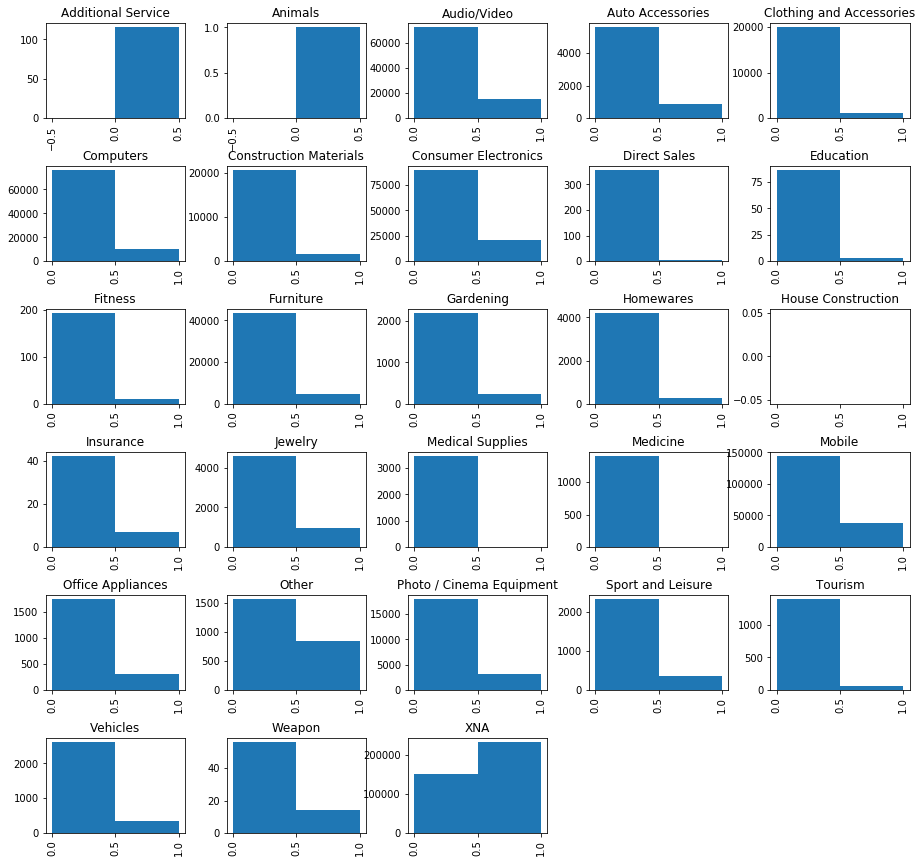

In [125]:
applications_history.NFLAG_INSURED_ON_APPROVAL.hist(by=applications_history['NAME_GOODS_CATEGORY'], bins=2, figsize=(15,15))

In [126]:
freq_encoder = applications_history["SELLERPLACE_AREA"].value_counts(normalize=True)
applications_history["SELLERPLACE_AREA_freq_enc"] = applications_history["SELLERPLACE_AREA"].map(freq_encoder)
applications_history[["SELLERPLACE_AREA", "SELLERPLACE_AREA_freq_enc"]].head(2)

,SELLERPLACE_AREA,SELLERPLACE_AREA_freq_enc
0,35,0.006267
1,-1,0.456633


In [127]:
applications_history['NAME_GOODS_CATEGORY'].value_counts()

XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers                   105769
Audio/Video                  99441
Furniture                    53656
Photo / Cinema Equipment     25021
Construction Materials       24995
Clothing and Accessories     23554
Auto Accessories              7381
Jewelry                       6290
Homewares                     5023
Medical Supplies              3843
Vehicles                      3370
Sport and Leisure             2981
Gardening                     2668
Other                         2554
Office Appliances             2333
Tourism                       1659
Medicine                      1550
Direct Sales                   446
Fitness                        209
Additional Service             128
Education                      107
Weapon                          77
Insurance                       64
Animals                          1
House Construction               1
Name: NAME_GOODS_CAT

In [128]:
freq_encoder = applications_history["NAME_GOODS_CATEGORY"].value_counts(normalize=True)
applications_history["NAME_GOODS_CATEGORY_freq_enc"] = applications_history["NAME_GOODS_CATEGORY"].map(freq_encoder)
applications_history[["NAME_GOODS_CATEGORY", "NAME_GOODS_CATEGORY_freq_enc"]].head(2)

,NAME_GOODS_CATEGORY,NAME_GOODS_CATEGORY_freq_enc
0,Mobile,0.134538
1,XNA,0.569274


In [129]:
applications_history = applications_history.drop('NAME_GOODS_CATEGORY', axis = 1)

### SELLERPLACE_AREA

In [130]:
applications_history.SELLERPLACE_AREA.value_counts(dropna=False)

-1       762675
 0        60523
 50       37401
 30       34423
 20       33840
          ...  
 1114         1
 2345         1
 1112         1
 4186         1
 1023         1
Name: SELLERPLACE_AREA, Length: 2097, dtype: int64

In [131]:
freq_encoder = applications_history["SELLERPLACE_AREA"].value_counts(normalize=True)
applications_history["SELLERPLACE_AREA_freq_enc"] = applications_history["SELLERPLACE_AREA"].map(freq_encoder)
applications_history[["SELLERPLACE_AREA", "SELLERPLACE_AREA_freq_enc"]].head(2)

,SELLERPLACE_AREA,SELLERPLACE_AREA_freq_enc
0,35,0.006267
1,-1,0.456633


In [132]:
 applications_history["SELLERPLACE_AREA"].value_counts(normalize=True, dropna=False)

-1       4.566331e-01
 0       3.623667e-02
 50      2.239294e-02
 30      2.060993e-02
 20      2.026088e-02
             ...     
 1114    5.987257e-07
 2345    5.987257e-07
 1112    5.987257e-07
 4186    5.987257e-07
 1023    5.987257e-07
Name: SELLERPLACE_AREA, Length: 2097, dtype: float64

In [133]:
def pop_obj(df, column, suffix):
    df[column] = df[column].astype(np.object)    
    mask =df.loc[df[column]!=-1, column].value_counts()
    area = pd.qcut(mask, 3, ['UNPOPULAR_'+suffix,'NORM_'+suffix,'POPULAR_'+suffix]).reset_index().rename(columns={"index": column, column: "DESCRIPCION_"+suffix}, errors="raise")
    df = df.merge(area , on = column,how =  "left")
    df["DESCRIPCION_"+suffix] = df["DESCRIPCION_"+suffix].cat.add_categories('MISSING_AREA')
    df["DESCRIPCION_"+suffix] = df["DESCRIPCION_"+suffix].fillna('MISSING_AREA')    
    return df

In [134]:
applications_history = pop_obj(applications_history, 'SELLERPLACE_AREA', 'AREA')

In [135]:
applications_history = applications_history.drop('SELLERPLACE_AREA', axis = 1)

### Кодирование

In [136]:
def dummi(df, colunms):
    df_dumm  = pd.get_dummies(df[colunms])
    df = df.drop(colunms, axis=1)
    df = pd.concat([df['APPLICATION_NUMBER'], df_dumm], axis=1)
    return df

In [137]:
dum = list(applications_history.select_dtypes(include=[np.object]).columns)
dum.remove('NAME_CONTRACT_STATUS')
dum.remove('APPLICATION_NUMBER')
dum.append('DESCRIPCION_AREA')
applications_dum = dummi(applications_history, dum)

In [138]:
applications_dum = applications_dum.groupby('APPLICATION_NUMBER').sum().reset_index()

In [139]:
train,test = merge_table(applications_dum, train=train, test=test)

### не Approved

In [140]:
mask = applications_history["NAME_CONTRACT_STATUS"] != "Approved"
cont = applications_history[mask]
cont = pd.get_dummies(cont["NAME_CONTRACT_STATUS"])

In [141]:
cont = pd.concat([applications_history.loc[applications_history["NAME_CONTRACT_STATUS"] != "Approved", "APPLICATION_NUMBER"], cont], axis=1)

In [142]:
cont = cont.groupby(['APPLICATION_NUMBER']).sum()

In [143]:
train,test=  merge_table(df = cont , train=train, test=test)

###  Approved, численные признаки

In [144]:
mask = applications_history["NAME_CONTRACT_STATUS"] == "Approved"
applications_history = applications_history[mask]
mask = applications_history["NFLAG_INSURED_ON_APPROVAL"].notnull()
applications_history = applications_history[mask]

In [145]:
mask = applications_history["NFLAG_INSURED_ON_APPROVAL"] == 0
app0 = applications_history[mask].groupby("APPLICATION_NUMBER").count()['NFLAG_INSURED_ON_APPROVAL'].reset_index().rename(columns={"NFLAG_INSURED_ON_APPROVAL": "NFLAG_INSURED_ON_APPROVAL_0"}, errors="raise")
mask = applications_history["NFLAG_INSURED_ON_APPROVAL"] == 1
app1 = applications_history[mask].groupby("APPLICATION_NUMBER").count()['NFLAG_INSURED_ON_APPROVAL'].reset_index().rename(columns={"NFLAG_INSURED_ON_APPROVAL": "NFLAG_INSURED_ON_APPROVAL_1"}, errors="raise")

In [146]:
app = app0.merge(app1 , on = 'APPLICATION_NUMBER' ,how =  "outer").fillna(0)
app[['NFLAG_INSURED_ON_APPROVAL_1', 'NFLAG_INSURED_ON_APPROVAL_0']] = app[['NFLAG_INSURED_ON_APPROVAL_1', 'NFLAG_INSURED_ON_APPROVAL_0']].astype('int32')
app['ratio_nflag_1_0'] = app['NFLAG_INSURED_ON_APPROVAL_1']/(1+app['NFLAG_INSURED_ON_APPROVAL_0'])
app = app.drop('NFLAG_INSURED_ON_APPROVAL_1', axis=1)
app = app.drop('NFLAG_INSURED_ON_APPROVAL_0', axis=1)
app

,APPLICATION_NUMBER,ratio_nflag_1_0
0,123423340,0.0
1,123423341,0.0
2,123423342,1.0
3,123423343,0.0
4,123423344,0.0
...,...,...
337335,123779557,1.0
337336,123779560,1.0
337337,123779564,2.0
337338,123779584,2.0


In [147]:
train,test=  merge_table(df = app , train=train, test=test, int_type=False)

applications_history - дел

арея - уникальность, в скольких локациях кредиты. Тогда не надо редкие отмечать.

In [148]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

In [149]:
aggs =dict.fromkeys(app_num, [np.mean, np.std, np.sum, "max", 'min'])

In [150]:
#mask = applications_history["NFLAG_INSURED_ON_APPROVAL"] == 0
stats_appr0 = create_numerical_aggs(
    applications_history, groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="", suffix=""
)
stats_appr0.head(n=6)

,APPLICATION_NUMBER,AMOUNT_ANNUITY_MEAN,AMOUNT_ANNUITY_STD,AMOUNT_ANNUITY_SUM,AMOUNT_ANNUITY_MAX,AMOUNT_ANNUITY_MIN,AMT_APPLICATION_MEAN,AMT_APPLICATION_STD,AMT_APPLICATION_SUM,AMT_APPLICATION_MAX,...,DAYS_TERMINATION_MEAN,DAYS_TERMINATION_STD,DAYS_TERMINATION_SUM,DAYS_TERMINATION_MAX,DAYS_TERMINATION_MIN,NFLAG_INSURED_ON_APPROVAL_MEAN,NFLAG_INSURED_ON_APPROVAL_STD,NFLAG_INSURED_ON_APPROVAL_SUM,NFLAG_INSURED_ON_APPROVAL_MAX,NFLAG_INSURED_ON_APPROVAL_MIN
0,123423340,3951.000,NaN,3951.000,3951.000,3951.000,24835.500,NaN,24835.50,24835.5,...,1612.000000,NaN,1612.0,1612.0,1612.0,0.000000,NaN,0.0,0.0,0.0
1,123423341,9251.775,NaN,9251.775,9251.775,9251.775,179055.000,NaN,179055.00,179055.0,...,17.000000,NaN,17.0,17.0,17.0,0.000000,NaN,0.0,0.0,0.0
2,123423342,56553.990,46332.557777,169661.970,98356.995,6737.310,435436.500,424161.620549,1306309.50,900000.0,...,1047.333333,806.196213,3142.0,1976.0,527.0,0.666667,0.57735,2.0,1.0,0.0
3,123423343,5357.250,NaN,5357.250,5357.250,5357.250,24282.000,NaN,24282.00,24282.0,...,714.000000,NaN,714.0,714.0,714.0,0.000000,NaN,0.0,0.0,0.0
4,123423344,4813.200,NaN,4813.200,4813.200,4813.200,44617.500,NaN,44617.50,44617.5,...,460.000000,NaN,460.0,460.0,460.0,0.000000,NaN,0.0,0.0,0.0
5,123423345,17314.110,11828.872935,69256.440,29027.520,2482.920,326707.335,267374.855438,1306829.34,675000.0,...,139.250000,196.591582,557.0,416.0,-1.0,0.000000,0.00000,0.0,0.0,0.0


In [151]:
# mask = applications_history["NFLAG_INSURED_ON_APPROVAL"] == 1
# stats_appr1 = create_numerical_aggs(
#     applications_history[mask], groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="", suffix="_NFLAG_1"
# )
# stats_appr1.head(n=6)

In [152]:
train,test=  merge_table(df = stats_appr0 , train=train, test=test,int_type=False)
# train,test,sample_submit=  merge_table(df = stats_appr1 , train=train, test=test, sample_submit=sample_submit,int_type=False)

In [153]:
train

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE,NAME_CONTRACT_TYPE_Cash,NAME_CONTRACT_TYPE_Credit Card,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,...,DAYS_TERMINATION_MEAN,DAYS_TERMINATION_STD,DAYS_TERMINATION_SUM,DAYS_TERMINATION_MAX,DAYS_TERMINATION_MIN,NFLAG_INSURED_ON_APPROVAL_MEAN,NFLAG_INSURED_ON_APPROVAL_STD,NFLAG_INSURED_ON_APPROVAL_SUM,NFLAG_INSURED_ON_APPROVAL_MAX,NFLAG_INSURED_ON_APPROVAL_MIN
0,123687442,0,Cash,0,0,2,0,1,0,0,...,927.333333,1264.873248,2782.0,2368.0,-1.0,0.333333,0.577350,1.0,1.0,0.0
1,123597908,1,Cash,2,0,4,0,0,0,0,...,465.500000,74.246212,931.0,518.0,413.0,0.000000,0.000000,0.0,0.0,0.0
2,123526683,0,Cash,4,1,3,0,0,3,0,...,1219.250000,915.828723,4877.0,2440.0,235.0,0.250000,0.500000,1.0,1.0,0.0
3,123710391,1,Cash,0,0,2,0,0,0,0,...,797.500000,1129.249530,1595.0,1596.0,-1.0,0.000000,0.000000,0.0,0.0,0.0
4,123590329,1,Cash,5,0,7,0,1,1,0,...,1167.000000,237.587878,2334.0,1335.0,999.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,123458312,0,Cash,1,0,5,0,0,0,0,...,1256.250000,699.457587,5025.0,2228.0,609.0,0.500000,0.577350,2.0,1.0,0.0
110089,123672463,0,Cash,3,2,7,0,0,6,0,...,443.800000,546.147141,2219.0,1185.0,-1.0,0.200000,0.447214,1.0,1.0,0.0
110090,123723001,0,Cash,0,0,1,0,0,1,0,...,280.000000,347.896536,560.0,526.0,34.0,0.500000,0.707107,1.0,1.0,0.0
110091,123554358,0,Cash,1,0,2,0,0,0,0,...,303.000000,-1.000000,303.0,303.0,303.0,0.000000,-1.000000,0.0,0.0,0.0


In [154]:
test

,APPLICATION_NUMBER,NAME_CONTRACT_TYPE,NAME_CONTRACT_TYPE_Cash,NAME_CONTRACT_TYPE_Credit Card,NAME_PAYMENT_TYPE_Cash through the bank,NAME_PAYMENT_TYPE_Cashless from the account of the employer,NAME_PAYMENT_TYPE_Non-cash from your account,NAME_PAYMENT_TYPE_XNA,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_HC,...,DAYS_TERMINATION_MEAN,DAYS_TERMINATION_STD,DAYS_TERMINATION_SUM,DAYS_TERMINATION_MAX,DAYS_TERMINATION_MIN,NFLAG_INSURED_ON_APPROVAL_MEAN,NFLAG_INSURED_ON_APPROVAL_STD,NFLAG_INSURED_ON_APPROVAL_SUM,NFLAG_INSURED_ON_APPROVAL_MAX,NFLAG_INSURED_ON_APPROVAL_MIN
0,123724268,Cash,0,3,0,0,0,4,0,0,...,177.000000,251.730014,354.0,355.0,-1.0,0.000000,0.000000,0.0,0.0,0.0
1,123456549,Cash,1,0,2,0,0,0,0,0,...,184.500000,262.336616,369.0,370.0,-1.0,0.500000,0.707107,1.0,1.0,0.0
2,123428178,Credit Card,5,0,6,0,0,2,0,2,...,1030.600000,1104.685611,5153.0,2761.0,283.0,0.600000,0.547723,3.0,1.0,0.0
3,123619984,Cash,0,0,1,0,0,0,0,0,...,-1.000000,-1.000000,-1.0,-1.0,-1.0,0.000000,-1.000000,0.0,0.0,0.0
4,123671104,Cash,1,0,4,0,0,1,1,0,...,1230.333333,493.702677,3691.0,1732.0,745.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165136,123487967,Cash,2,4,1,0,0,5,0,0,...,-1.000000,0.000000,-2.0,-1.0,-1.0,0.500000,0.707107,1.0,1.0,0.0
165137,123536402,Cash,0,0,2,0,0,0,0,0,...,50.000000,72.124892,100.0,101.0,-1.0,0.000000,0.000000,0.0,0.0,0.0
165138,123718238,Cash,9,1,9,0,0,1,0,1,...,1111.000000,1133.408355,5555.0,2572.0,-1.0,0.600000,0.547723,3.0,1.0,0.0
165139,123631557,Cash,6,0,5,0,0,2,0,0,...,683.500000,623.143242,4101.0,1585.0,-1.0,0.833333,0.408248,5.0,1.0,0.0


## bki

In [155]:
bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  object 
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [156]:
bki['AMT_CREDIT_SUM_DEBT_minus'] = 0
bki.loc[bki['AMT_CREDIT_SUM_DEBT']<0,'AMT_CREDIT_SUM_DEBT_minus'] = 1
bki.loc[bki['AMT_CREDIT_SUM_DEBT']<0, 'AMT_CREDIT_SUM_DEBT'] = -bki.loc[bki['AMT_CREDIT_SUM_DEBT']<0, 'AMT_CREDIT_SUM_DEBT'] 
bki['AMT_CREDIT_SUM_DEBT'] = bki['AMT_CREDIT_SUM_DEBT'].fillna(-1)

In [157]:
bki.loc[bki['AMT_CREDIT_SUM_LIMIT']<0,'AMT_CREDIT_SUM_LIMIT'] = 0
bki['AMT_CREDIT_SUM_LIMIT'] = bki['AMT_CREDIT_SUM_LIMIT'].fillna(-1)

In [158]:
bki['AMT_CREDIT_SUM_OVERDUE'] = bki['AMT_CREDIT_SUM_OVERDUE'].fillna(-1)

In [159]:
bki['AMT_CREDIT_SUM'] = bki['AMT_CREDIT_SUM'].fillna(-1)

In [160]:
bki['AMT_CREDIT_SUM'] = bki['AMT_CREDIT_SUM'].astype(int)
bki['AMT_CREDIT_SUM_DEBT'] = bki['AMT_CREDIT_SUM_DEBT'].astype(int)
bki['AMT_CREDIT_SUM_LIMIT'] = bki['AMT_CREDIT_SUM_LIMIT'].astype(int)
bki['AMT_CREDIT_SUM_OVERDUE'] = bki['AMT_CREDIT_SUM_OVERDUE'].astype(int)

In [161]:
bki['AMT_CREDIT_SUM_OVERDUE'].value_counts()

0        943008
4           162
9            53
13           42
18           40
          ...  
15651         1
804           1
8487          1
289           1
4320          1
Name: AMT_CREDIT_SUM_OVERDUE, Length: 874, dtype: int64

In [162]:
bki.CREDIT_ACTIVE.value_counts()

Closed      594315
Active      347323
Sold          3583
Bad debt        13
Name: CREDIT_ACTIVE, dtype: int64

In [163]:
bki = bki.loc[bki['CREDIT_ACTIVE']!='Bad debt']

In [164]:
bki.loc[bki['CREDIT_CURRENCY']=='currency 4','CREDIT_CURRENCY'] = 'currency_3_4'
bki.loc[bki['CREDIT_CURRENCY']=='currency 3','CREDIT_CURRENCY']= 'currency_3_4'

In [165]:
bki.CREDIT_TYPE.value_counts()

Consumer credit                                 688422
Credit card                                     222234
Car loan                                         15348
Mortgage                                         10161
Microloan                                         6788
Loan for business development                     1055
Another type of loan                               586
Unknown type of loan                               300
Loan for working capital replenishment             261
Cash loan (non-earmarked)                           31
Real estate loan                                    16
Loan for the purchase of equipment                  14
Loan for purchase of shares (margin lending)         4
Mobile operator loan                                 1
Name: CREDIT_TYPE, dtype: int64

In [166]:
mask = bki["CREDIT_TYPE"].value_counts()
bki.loc[bki['CREDIT_TYPE'].isin(mask.index[mask<299]), 'CREDIT_TYPE'] = 'other_specific'

In [167]:
bki.CREDIT_TYPE.value_counts()

Consumer credit                  688422
Credit card                      222234
Car loan                          15348
Mortgage                          10161
Microloan                          6788
Loan for business development      1055
Another type of loan                586
other_specific                      327
Unknown type of loan                300
Name: CREDIT_TYPE, dtype: int64

In [168]:
bki['CREDIT_TYPE'] = bki['CREDIT_TYPE'].str.upper()
bki['CREDIT_TYPE'] = bki['CREDIT_TYPE'].str.replace(' ', '_')

In [169]:
freq_encoder = bki["BUREAU_ID"].value_counts(normalize=True)
bki["BUREAU_ID_freq_enc"] = bki["BUREAU_ID"].map(freq_encoder)
bki[["BUREAU_ID", "BUREAU_ID_freq_enc"]].head(2)

,BUREAU_ID,BUREAU_ID_freq_enc
0,5223613,0.000001
1,6207544,0.000003


In [170]:
bki['BUREAU_ID'] = bki['BUREAU_ID'].astype(np.object)

In [171]:
dum = bki.select_dtypes(include=[np.object]).columns
dum = dum.drop('BUREAU_ID')
dum = dum.drop('APPLICATION_NUMBER')
bki_dum = dummi(bki, dum)
bki_dum = bki_dum.groupby('APPLICATION_NUMBER').sum().reset_index()

In [172]:
train,test=  merge_table(df = bki_dum , train=train, test=test)

In [173]:
bki_num = list(bki.select_dtypes(include=[np.number]))                      
bki[bki_num].describe()

,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,AMT_CREDIT_SUM_DEBT_minus,BUREAU_ID_freq_enc
count,945221.000000,945221.000000,886785.000000,596270.000000,3.265500e+05,945221.000000,9.452210e+05,9.452210e+05,9.452210e+05,9.452210e+05,945221.000000,2.693300e+05,945221.000000,9.452210e+05
mean,1142.206344,0.766250,1819.612095,1017.998749,3.782722e+03,0.006329,3.547743e+05,1.158290e+05,4.110868e+03,3.725383e+01,594.048671,1.646679e+04,0.004965,1.588566e-06
std,795.042982,35.142384,4684.478560,715.014676,2.133842e+05,0.094853,1.078786e+06,5.893216e+05,3.675759e+04,5.122293e+03,721.504068,3.937657e+05,0.070287,7.516463e-07
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,1.057954e-06
25%,474.000000,0.000000,383.000000,426.000000,0.000000e+00,0.000000,5.121000e+04,0.000000e+00,-1.000000e+00,0.000000e+00,33.000000,0.000000e+00,0.000000,1.057954e-06
50%,987.000000,0.000000,863.000000,897.000000,0.000000e+00,0.000000,1.254690e+05,0.000000e+00,0.000000e+00,0.000000e+00,396.000000,0.000000e+00,0.000000,1.057954e-06
75%,1666.000000,0.000000,1504.000000,1489.000000,0.000000e+00,0.000000,3.150000e+05,2.056000e+03,0.000000e+00,0.000000e+00,908.000000,1.350000e+04,0.000000,2.115907e-06
max,2922.000000,2792.000000,42060.000000,42023.000000,1.159872e+08,7.000000,3.960000e+08,6.544140e+07,4.705600e+06,2.387232e+06,41943.000000,1.184534e+08,1.000000,7.405675e-06


In [174]:
mask = bki.DAYS_CREDIT_ENDDATE < 14600
bki = bki[mask]

In [175]:
mask =bki.DAYS_ENDDATE_FACT< 14600
bki =  bki[mask]

In [176]:
aggs =dict.fromkeys(app_num, [np.mean, np.std, np.sum, "max", 'min'])

In [177]:
# mask = applications_history["NFLAG_INSURED_ON_APPROVAL"] == 0
# stats_appr0 = create_numerical_aggs(
#     applications_history[mask], groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="", suffix="_NFLAG_0"
# )
# stats_appr0.head(n=6)

In [178]:
bki_num = list(bki.select_dtypes(include=[np.number]))    

In [179]:
aggs =dict.fromkeys(bki_num, [np.mean, np.std, np.sum, "max", 'min'])

In [180]:
stats = create_numerical_aggs(
    bki, groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="", suffix=""
)
stats.head(n=6)

,APPLICATION_NUMBER,DAYS_CREDIT_MEAN,DAYS_CREDIT_STD,DAYS_CREDIT_SUM,DAYS_CREDIT_MAX,DAYS_CREDIT_MIN,CREDIT_DAY_OVERDUE_MEAN,CREDIT_DAY_OVERDUE_STD,CREDIT_DAY_OVERDUE_SUM,CREDIT_DAY_OVERDUE_MAX,...,AMT_CREDIT_SUM_DEBT_MINUS_MEAN,AMT_CREDIT_SUM_DEBT_MINUS_STD,AMT_CREDIT_SUM_DEBT_MINUS_SUM,AMT_CREDIT_SUM_DEBT_MINUS_MAX,AMT_CREDIT_SUM_DEBT_MINUS_MIN,BUREAU_ID_FREQ_ENC_MEAN,BUREAU_ID_FREQ_ENC_STD,BUREAU_ID_FREQ_ENC_SUM,BUREAU_ID_FREQ_ENC_MAX,BUREAU_ID_FREQ_ENC_MIN
0,123423341,1041.666667,396.001683,3125.0,1437.0,645.0,0.0,0.0,0,0,...,0.0,0.0,0,0,0,0.000001,0.000000e+00,0.000003,0.000001,0.000001
1,123423342,2111.000000,671.751442,4222.0,2586.0,1636.0,0.0,0.0,0,0,...,0.0,0.0,0,0,0,0.000002,1.496172e-06,0.000004,0.000003,0.000001
2,123423343,408.000000,NaN,408.0,408.0,408.0,0.0,NaN,0,0,...,0.0,NaN,0,0,0,0.000002,NaN,0.000002,0.000002,0.000002
3,123423344,373.000000,NaN,373.0,373.0,373.0,0.0,NaN,0,0,...,0.0,NaN,0,0,0,0.000001,NaN,0.000001,0.000001,0.000001
4,123423347,1097.000000,0.000000,2194.0,1097.0,1097.0,0.0,0.0,0,0,...,0.0,0.0,0,0,0,0.000002,1.496172e-06,0.000004,0.000003,0.000001
5,123423348,1757.666667,1057.864043,5273.0,2882.0,782.0,0.0,0.0,0,0,...,0.0,0.0,0,0,0,0.000002,6.108098e-07,0.000005,0.000002,0.000001


In [181]:
train,test=  merge_table(df = stats , train=train, test=test,int_type=False)

## client_profile

In [182]:
client_profile= pd.read_csv("C:/Users/elousiren/Desktop/git_presentation/playground/gb/sport/kyrs/client_profile.csv")

In [183]:
client_num = list(client_profile.select_dtypes(include=[np.number]))
client_num.remove('APPLICATION_NUMBER')                            
client_profile[client_num].describe()

,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,250000.000000,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,0.057072,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,0.231981,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,0.000000,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,0.000000,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,0.000000,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,1.000000,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [184]:
aggs = {
    "TOTAL_SALARY": ["mean"],
    "AMOUNT_CREDIT": ["mean"],
}

stats = create_numerical_aggs(
    client_profile, groupby_id="EDUCATION_LEVEL", aggs=aggs, suffix="_BY_EDUCATION"
)
stats

,EDUCATION_LEVEL,TOTAL_SALARY_MEAN_BY_EDUCATION,AMOUNT_CREDIT_MEAN_BY_EDUCATION
0,Academic degree,244621.323529,729561.606618
1,Higher education,208989.672806,689809.957142
2,Incomplete higher,181446.844502,565921.004786
3,Lower secondary,130223.217137,491498.704966
4,Secondary / secondary special,155414.744584,571624.325064


In [185]:
profile_stats = client_profile[["APPLICATION_NUMBER", "EDUCATION_LEVEL", "TOTAL_SALARY", "AMOUNT_CREDIT"]]
profile_stats = profile_stats.merge(
    stats, how="left", on="EDUCATION_LEVEL"
)
profile_stats["TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = profile_stats["TOTAL_SALARY"] / profile_stats["TOTAL_SALARY_MEAN_BY_EDUCATION"]
profile_stats["DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = profile_stats["TOTAL_SALARY"] - profile_stats["TOTAL_SALARY_MEAN_BY_EDUCATION"]
profile_stats.head(n=3)

,APPLICATION_NUMBER,EDUCATION_LEVEL,TOTAL_SALARY,AMOUNT_CREDIT,TOTAL_SALARY_MEAN_BY_EDUCATION,AMOUNT_CREDIT_MEAN_BY_EDUCATION,TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION,DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION
0,123666076,Incomplete higher,157500.0,270000.0,181446.844502,565921.004786,0.868023,-23946.844502
1,123423688,Secondary / secondary special,270000.0,536917.5,155414.744584,571624.325064,1.737287,114585.255416
2,123501780,Incomplete higher,427500.0,239850.0,181446.844502,565921.004786,2.356062,246053.155498


In [186]:
profile_stats

,APPLICATION_NUMBER,EDUCATION_LEVEL,TOTAL_SALARY,AMOUNT_CREDIT,TOTAL_SALARY_MEAN_BY_EDUCATION,AMOUNT_CREDIT_MEAN_BY_EDUCATION,TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION,DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION
0,123666076,Incomplete higher,157500.0,270000.0,181446.844502,565921.004786,0.868023,-23946.844502
1,123423688,Secondary / secondary special,270000.0,536917.5,155414.744584,571624.325064,1.737287,114585.255416
2,123501780,Incomplete higher,427500.0,239850.0,181446.844502,565921.004786,2.356062,246053.155498
3,123588799,Secondary / secondary special,112500.0,254700.0,155414.744584,571624.325064,0.723870,-42914.744584
4,123647485,Lower secondary,130500.0,614574.0,130223.217137,491498.704966,1.002125,276.782863
...,...,...,...,...,...,...,...,...
249995,123657254,Higher education,216000.0,45000.0,208989.672806,689809.957142,1.033544,7010.327194
249996,123645397,Higher education,103500.0,675000.0,208989.672806,689809.957142,0.495240,-105489.672806
249997,123504053,Secondary / secondary special,202500.0,1078200.0,155414.744584,571624.325064,1.302965,47085.255416
249998,123547316,Secondary / secondary special,135000.0,500211.0,155414.744584,571624.325064,0.868643,-20414.744584


In [187]:
client_profile = client_profile.merge(profile_stats[['APPLICATION_NUMBER','TOTAL_SALARY_MEAN_BY_EDUCATION','AMOUNT_CREDIT_MEAN_BY_EDUCATION','TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION','DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION']] , on = 'APPLICATION_NUMBER' ,how =  "left")

In [188]:
client_profile['BKI_REQ_COUNT'] = client_profile[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']].sum(axis=1)
client_profile['BKI_REQ_KYRTOSIS'] = client_profile[['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON','AMT_REQ_CREDIT_BUREAU_QRT']].kurtosis(axis=1)

In [189]:
client_profile.loc[client_profile['DAYS_ON_LAST_JOB']==365243, 'DAYS_ON_LAST_JOB']=-1
client_profile.loc[client_profile['DAYS_ON_LAST_JOB']!=-1, 'DAYS_ON_LAST_JOB']=round(client_profile.loc[client_profile['DAYS_ON_LAST_JOB']!=-1, 'DAYS_ON_LAST_JOB']/365,2)

In [190]:
client_profile['AGE'] = round(client_profile['AGE']/365)


In [191]:
client_profile['GROUP_AGE'] = pd.qcut(client_profile['AGE'], 3, ['young','middle','old'])

In [192]:
client_profile

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_SALARY_MEAN_BY_EDUCATION,AMOUNT_CREDIT_MEAN_BY_EDUCATION,TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION,DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION,BKI_REQ_COUNT,BKI_REQ_KYRTOSIS,GROUP_AGE
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,23.0,...,0.0,1.0,2.0,181446.844502,565921.004786,0.868023,-23946.844502,1.0,5.0,young
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,64.0,...,0.0,1.0,1.0,155414.744584,571624.325064,1.737287,114585.255416,1.0,5.0,old
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,39.0,...,NaN,NaN,NaN,181446.844502,565921.004786,2.356062,246053.155498,0.0,NaN,middle
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,39.0,...,0.0,0.0,3.0,155414.744584,571624.325064,0.723870,-42914.744584,0.0,0.0,middle
4,123647485,M,0,130500.0,614574.0,19822.5,Lower secondary,Married,0.022625,63.0,...,0.0,0.0,6.0,130223.217137,491498.704966,1.002125,276.782863,1.0,5.0,old
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,123657254,M,0,216000.0,45000.0,2425.5,Higher education,Married,0.018850,52.0,...,0.0,1.0,3.0,208989.672806,689809.957142,1.033544,7010.327194,1.0,5.0,old
249996,123645397,M,0,103500.0,675000.0,28507.5,Higher education,Married,0.014520,54.0,...,0.0,0.0,0.0,208989.672806,689809.957142,0.495240,-105489.672806,0.0,0.0,old
249997,123504053,M,0,202500.0,1078200.0,38331.0,Secondary / secondary special,Single / not married,0.031329,23.0,...,0.0,1.0,4.0,155414.744584,571624.325064,1.302965,47085.255416,1.0,5.0,young
249998,123547316,F,0,135000.0,500211.0,38839.5,Secondary / secondary special,Married,0.030755,36.0,...,0.0,0.0,3.0,155414.744584,571624.325064,0.868643,-20414.744584,0.0,0.0,young


In [193]:
client_profile['GROUP_AGE_EDUCATION_LEVEL'] = client_profile['GROUP_AGE'].astype('object') + " | " + client_profile['EDUCATION_LEVEL'].astype('object')
client_profile['FAMILY_STATUS_EDUCATION_LEVEL'] = client_profile['EDUCATION_LEVEL'].astype('object')+ client_profile['FAMILY_STATUS'].astype('object')
client_profile['EDUCATION_LEVEL_GENDER'] = client_profile['EDUCATION_LEVEL'].astype('object')+ client_profile['GENDER'].astype('object')
client_profile['FAMILY_STATUS_GENDER'] = client_profile['GENDER'].astype('object')+ client_profile['FAMILY_STATUS'].astype('object')

In [194]:
client_profile['FAMILY_STATUS_EDUCATION_LEVEL'] = client_profile['EDUCATION_LEVEL'].astype('object')+ client_profile['FAMILY_STATUS'].astype('object')
client_profile['FAMILY_STATUS_GENDER'] = client_profile['GENDER'].astype('object')+ client_profile['FAMILY_STATUS'].astype('object')

In [195]:
client_profile = client_profile.loc[client_profile['GENDER']!='XNA']
client_profile = client_profile.loc[client_profile['FAMILY_STATUS']!='Unknown']
client_profile['FAMILY_STATUS'] = client_profile['FAMILY_STATUS'].str.replace(' / ', '_')
client_profile['FAMILY_STATUS'] = client_profile['FAMILY_STATUS'].str.replace('/', '_')
client_profile['FAMILY_STATUS'] = client_profile['FAMILY_STATUS'].str.replace(' ', '_')

In [196]:
client_profile['external_scoring_prod']= client_profile['EXTERNAL_SCORING_RATING_1'] *client_profile['EXTERNAL_SCORING_RATING_2']*client_profile['EXTERNAL_SCORING_RATING_3']
client_profile['external_scoring_weighted']= client_profile['EXTERNAL_SCORING_RATING_1']*2 +client_profile['EXTERNAL_SCORING_RATING_2']*1+client_profile['EXTERNAL_SCORING_RATING_3']*3

In [197]:
client_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249994 entries, 0 to 249999
Data columns (total 37 columns):
 #   Column                                    Non-Null Count   Dtype   
---  ------                                    --------------   -----   
 0   APPLICATION_NUMBER                        249994 non-null  int64   
 1   GENDER                                    249994 non-null  object  
 2   CHILDRENS                                 249994 non-null  int64   
 3   TOTAL_SALARY                              249994 non-null  float64 
 4   AMOUNT_CREDIT                             249994 non-null  float64 
 5   AMOUNT_ANNUITY                            249983 non-null  float64 
 6   EDUCATION_LEVEL                           249994 non-null  object  
 7   FAMILY_STATUS                             249994 non-null  object  
 8   REGION_POPULATION                         249994 non-null  float64 
 9   AGE                                       249994 non-null  float64 
 10  DAYS_ON_

In [198]:
client_profile["FAMILY_SIZE"].min()

1.0

In [199]:
client_profile["REGION_POPULATION"].min()

0.00029

In [200]:
client_profile["ratio_credit_to_annuity"] = client_profile['AMOUNT_CREDIT'] / client_profile["AMOUNT_ANNUITY"]
client_profile["ratio_annuity_to_salary"] = client_profile['AMOUNT_ANNUITY'] / client_profile["TOTAL_SALARY"]
client_profile["ratio_credit_to_salary"] = client_profile['AMOUNT_CREDIT'] / client_profile["TOTAL_SALARY"]
client_profile["total_salary_net"] = client_profile['TOTAL_SALARY'] - client_profile["AMOUNT_ANNUITY"]

In [201]:
client_profile["ratio_annuity_to_age"] = client_profile['AMOUNT_ANNUITY'] / client_profile["AGE"]
client_profile["ratio_credit_to_age"] = client_profile['AMOUNT_CREDIT'] / client_profile["AGE"]
client_profile["ratio_salary_to_experience"] = client_profile['TOTAL_SALARY'] / (client_profile["DAYS_ON_LAST_JOB"]+0.5)
client_profile["ratio_credit_to_experience"] = client_profile['AMOUNT_CREDIT'] / (client_profile["DAYS_ON_LAST_JOB"]+0.5)
client_profile["ratio_annuity_to_experience"] = client_profile['AMOUNT_ANNUITY'] / (client_profile["DAYS_ON_LAST_JOB"]+0.5)
client_profile['job'] = 0
client_profile.loc[client_profile['DAYS_ON_LAST_JOB']==0, 'job'] =1

In [202]:
client_profile["ratio_age_to_experience"] = client_profile['AGE'] / 1 +client_profile["DAYS_ON_LAST_JOB"]
# client_profile["ratio_salary_to_region_population"] = client_profile['TOTAL_SALARY'] * client_profile["REGION_POPULATION"]
client_profile["ratio_car_to_age"] = client_profile['OWN_CAR_AGE'] / client_profile["AGE"]

In [203]:
client_profile["expected_total_loss_1"] = client_profile['EXTERNAL_SCORING_RATING_1']*client_profile['AMOUNT_CREDIT'] 
client_profile["expected_total_loss_2"] = client_profile['EXTERNAL_SCORING_RATING_2']*client_profile['AMOUNT_CREDIT']
client_profile["expected_total_loss_3"] = client_profile['EXTERNAL_SCORING_RATING_3']*client_profile['AMOUNT_CREDIT']
client_profile["expected_mountly_loss_1"] = client_profile['EXTERNAL_SCORING_RATING_1']*client_profile['AMOUNT_ANNUITY'] 
client_profile["expected_mountly_loss_2"] = client_profile['EXTERNAL_SCORING_RATING_2']*client_profile['AMOUNT_ANNUITY']
client_profile["expected_mountly_loss_3"] = client_profile['EXTERNAL_SCORING_RATING_3']*client_profile['AMOUNT_ANNUITY']

In [204]:
client_profile["ratio_credit_per_family_size"] = client_profile['AMOUNT_CREDIT'] / client_profile["FAMILY_SIZE"]
client_profile["ratio_credit_per_children"] = client_profile['AMOUNT_CREDIT'] / (1+client_profile["CHILDRENS"])
client_profile["ratio_children_to_family_size"] = client_profile['CHILDRENS'] / (client_profile["FAMILY_SIZE"])
client_profile["ratio_salary_to_family_size"] = client_profile['TOTAL_SALARY'] / (client_profile["FAMILY_SIZE"])
client_profile["ratio_salary_per_children"] = client_profile['TOTAL_SALARY'] / (1+client_profile["CHILDRENS"])


In [205]:
client_score = ['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3']
for function_name in ["mean", "std", "max", 'min', 'var', 'nanmedian']:
    feature_name='EXTERNAL_SCORING_RATING_{}'.format(function_name)
    client_profile[feature_name]=eval("np.{}".format(function_name))(
    client_profile[client_score],axis=1
    )

C:\Users\elousiren\AppData\Roaming\Python\Python37\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [206]:
client_profile.BKI_REQ_COUNT.value_counts()

0.0      171704
1.0       52555
2.0       16582
3.0        5081
4.0        1680
5.0         818
6.0         414
7.0         298
8.0         189
9.0         175
10.0        123
11.0        110
12.0         82
13.0         67
14.0         32
15.0         28
16.0         25
17.0         16
18.0          5
19.0          3
26.0          1
22.0          1
262.0         1
23.0          1
27.0          1
21.0          1
20.0          1
Name: BKI_REQ_COUNT, dtype: int64

In [207]:
train,test=merge_table(df = client_profile , train=train, test=test,int_type=False)

## payments

In [208]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  object 
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 62.5+ MB


In [209]:
payments.describe()

,PREV_APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.023932e+06,1.023932e+06,1.023932e+06,1.023932e+06,1.023729e+06,1.023932e+06,1.023729e+06
mean,4.917253e+07,8.569114e-01,1.888052e+01,1.042505e+03,1.051378e+03,1.714263e+04,1.733931e+04
std,5.363093e+05,1.053180e+00,2.669996e+01,8.013580e+02,8.009974e+02,5.130650e+04,5.557338e+04
min,4.826822e+07,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,4.870325e+07,0.000000e+00,4.000000e+00,3.610000e+02,3.700000e+02,4.217445e+03,3.386205e+03
50%,4.916602e+07,1.000000e+00,8.000000e+00,8.170000e+02,8.260000e+02,8.878500e+03,8.115390e+03
75%,4.963797e+07,1.000000e+00,1.900000e+01,1.655000e+03,1.664000e+03,1.671229e+04,1.611140e+04
max,5.011171e+07,1.780000e+02,2.750000e+02,2.922000e+03,3.054000e+03,2.860377e+06,2.860377e+06


In [210]:
len(payments.NUM_INSTALMENT_NUMBER.unique())

243

In [211]:
payments['NUM_INSTALMENT_NUMBER'] = payments['NUM_INSTALMENT_NUMBER'].astype(np.object)   
payments['NUM_INSTALMENT_VERSION'] = payments['NUM_INSTALMENT_VERSION'].astype(np.object)   

In [212]:
dum = list(payments.select_dtypes(include=[np.object]).columns)
dum.remove('APPLICATION_NUMBER')
payments_dum = dummi(payments, dum)

In [213]:
payments_dum = payments_dum.groupby('APPLICATION_NUMBER').sum().reset_index()

In [214]:
train,test=  merge_table(df = payments_dum , train=train, test=test)

In [215]:
payments_col = list(payments.select_dtypes(include=[np.number]))
payments_col.remove('PREV_APPLICATION_NUMBER')
aggs =dict.fromkeys(payments_col, [np.mean, np.std, np.sum, "max", 'min'])

In [216]:
stats = create_numerical_aggs(
    payments, groupby_id="APPLICATION_NUMBER", aggs=aggs, prefix="", suffix=""
)
stats.head(n=6)

,APPLICATION_NUMBER,DAYS_INSTALMENT_MEAN,DAYS_INSTALMENT_STD,DAYS_INSTALMENT_SUM,DAYS_INSTALMENT_MAX,DAYS_INSTALMENT_MIN,DAYS_ENTRY_PAYMENT_MEAN,DAYS_ENTRY_PAYMENT_STD,DAYS_ENTRY_PAYMENT_SUM,DAYS_ENTRY_PAYMENT_MAX,...,AMT_INSTALMENT_MEAN,AMT_INSTALMENT_STD,AMT_INSTALMENT_SUM,AMT_INSTALMENT_MAX,AMT_INSTALMENT_MIN,AMT_PAYMENT_MEAN,AMT_PAYMENT_STD,AMT_PAYMENT_SUM,AMT_PAYMENT_MAX,AMT_PAYMENT_MIN
0,123423340,1634.000000,21.213203,3268.0,1649.0,1619.0,1644.000000,22.627417,3288.0,1660.0,...,10674.450,9508.394176,21348.90,17397.900,3951.000,10674.450,9508.394176,21348.90,17397.900,3951.000
1,123423341,220.000000,190.918831,440.0,355.0,85.0,237.000000,195.161472,474.0,375.0,...,9251.775,0.000000,18503.55,9251.775,9251.775,9251.775,0.000000,18503.55,9251.775,9251.775
2,123423344,706.000000,NaN,706.0,706.0,706.0,736.000000,NaN,736.0,736.0,...,4813.200,NaN,4813.20,4813.200,4813.200,4813.200,NaN,4813.20,4813.200,4813.200
3,123423345,293.000000,313.955411,586.0,515.0,71.0,317.000000,346.482323,634.0,562.0,...,15755.220,18769.866664,31510.44,29027.520,2482.920,15755.220,18769.866664,31510.44,29027.520,2482.920
4,123423346,1116.666667,803.729971,6700.0,2236.0,164.0,1120.333333,801.295118,6722.0,2234.0,...,9682.365,7336.991013,58094.19,16509.600,1834.290,9682.365,7336.991013,58094.19,16509.600,1834.290
5,123423347,324.000000,318.198052,648.0,549.0,99.0,330.500000,317.490945,661.0,555.0,...,21597.705,5249.376896,43195.41,25309.575,17885.835,21597.705,5249.376896,43195.41,25309.575,17885.835


## Модель и подготовка

In [217]:
train,test=merge_table(df = stats , train=train, test=test, int_type=False)

In [218]:
def make_conract_age(df):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    df['NAME_CONTRACT_TYPE_GROUP_AGE'] =df['GROUP_AGE'].astype('object')+ df['NAME_CONTRACT_TYPE'].astype('object')
    df['NAME_CONTRACT_TYPE_GROUP_AGE'] =df['NAME_CONTRACT_TYPE_GROUP_AGE'].astype('category')
    return df

In [219]:
train = make_conract_age(train)
test = make_conract_age(test)

In [220]:
train = train.rename(columns={"NAME_CONTRACT_TYPE":"NAME_CONTRACT_TYPE_new"}, errors="raise")
test = test.rename(columns={"NAME_CONTRACT_TYPE":"NAME_CONTRACT_TYPE_new"}, errors="raise")

In [ ]:
test = test.drop( 'APPLICATION_NUMBER', axis=1)

In [256]:
x_train = train.drop(['TARGET', 'APPLICATION_NUMBER'], axis=1)
y_train = train['TARGET']
x_train_par, x_valid_par = train_test_split(x_train, train_size=0.75, random_state=42)
y_train_par, y_valid_par = train_test_split(y_train, train_size=0.75, random_state=42)

In [257]:
num = list(x_train.select_dtypes(include=[np.number]).columns)
transformer = RobustScaler().fit(x_train[num])
transformer.transform(x_train[num])
transformer.transform(x_train_par[num])
transformer.transform(x_valid_par[num])
transformer.transform(test[num])

array([[-0.33333333,  3.        , -0.66666667, ...,  0.13097286,
         0.06885959,  0.97438891],
       [ 0.        ,  0.        ,  0.        , ...,  0.67881958,
         1.73720247, -0.17101261],
       [ 1.33333333,  0.        ,  1.33333333, ...,  0.68708176,
         1.81700366,  5.45666602],
       ...,
       [ 2.66666667,  1.        ,  2.33333333, ...,  8.54417596,
        10.16048779, -0.32761504],
       [ 1.66666667,  0.        ,  1.        , ...,  3.44957701,
         0.95809702,  0.20762294],
       [-0.33333333,  0.        ,  0.        , ..., -0.14614849,
        -0.30648728,  0.01199187]])

In [258]:
params = {
    "n_estimators": 1500,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 10,
    "verbose": 50,
    "max_depth": 4,
    "l2_leaf_reg": 100,
    'learning_rate': 0.1,
    "early_stopping_rounds": 500,
    "thread_count": 6,
    "random_seed": 42
}

In [259]:
for column in list(x_train.select_dtypes(include=[np.object]).columns):
    x_train[column] = x_train[column].astype('category')
    x_train_par[column] = x_train_par[column].astype('category')
    x_valid_par[column] = x_valid_par[column].astype('category')
    test[column] = test[column].astype('category')
cat_f = list(x_train.select_dtypes(include=['category']).columns)
cat_f

['NAME_CONTRACT_TYPE_new',
 'GENDER',
 'EDUCATION_LEVEL',
 'FAMILY_STATUS',
 'GROUP_AGE',
 'GROUP_AGE_EDUCATION_LEVEL',
 'FAMILY_STATUS_EDUCATION_LEVEL',
 'EDUCATION_LEVEL_GENDER',
 'FAMILY_STATUS_GENDER',
 'NAME_CONTRACT_TYPE_GROUP_AGE']

In [225]:
cat_cat = cb.CatBoostClassifier(**params)
cat_cat.fit(x_train_par, y_train_par,
            eval_set=[(x_train_par, y_train_par), (x_valid_par, y_valid_par)],
            cat_features = cat_f)

0:	test: 0.5627737	test1: 0.5677292	best: 0.5677292 (0)	total: 383ms	remaining: 9m 34s
50:	test: 0.7159745	test1: 0.7243851	best: 0.7243851 (50)	total: 9.1s	remaining: 4m 18s
100:	test: 0.7245447	test1: 0.7274954	best: 0.7274954 (100)	total: 18.4s	remaining: 4m 14s
150:	test: 0.7293281	test1: 0.7291173	best: 0.7291533 (140)	total: 27s	remaining: 4m
200:	test: 0.7308766	test1: 0.7294779	best: 0.7294877 (174)	total: 34.2s	remaining: 3m 40s
250:	test: 0.7320840	test1: 0.7294457	best: 0.7295875 (244)	total: 40.8s	remaining: 3m 22s
300:	test: 0.7332388	test1: 0.7292172	best: 0.7295875 (244)	total: 47.5s	remaining: 3m 9s
350:	test: 0.7345547	test1: 0.7292327	best: 0.7295875 (244)	total: 54s	remaining: 2m 56s
400:	test: 0.7360159	test1: 0.7293551	best: 0.7295875 (244)	total: 1m	remaining: 2m 45s
450:	test: 0.7369284	test1: 0.7296018	best: 0.7296217 (424)	total: 1m 6s	remaining: 2m 35s
500:	test: 0.7395048	test1: 0.7297351	best: 0.7298576 (474)	total: 1m 13s	remaining: 2m 26s
550:	test: 0.7408

In [226]:
# train_score = roc_auc_score(y_train, my_classifier_cat.predict_proba(x_train)[:,1])
# valid_score= roc_auc_score(y_valid, my_classifier_cat.predict_proba(x_valid)[:,1])

# print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}")

In [227]:

importance = permutation_importance(
    cat_cat, x_valid_par, y_valid_par, scoring="roc_auc", n_jobs=-1, random_state=42
)

In [228]:
importance_scores = pd.DataFrame({
    "features": x_valid_par.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)

In [233]:
importance_scores.head(40)

,features,importance-mean,importance-std
0,EXTERNAL_SCORING_RATING_mean,0.033945,0.001080
1,EXTERNAL_SCORING_RATING_min,0.009081,0.002386
2,ratio_credit_to_annuity,0.008291,0.000655
3,ratio_credit_to_experience,0.004812,0.000577
4,EXTERNAL_SCORING_RATING_3,0.004566,0.000936
5,GENDER,0.002977,0.000353
6,AGE,0.002895,0.000499
7,ratio_salary_to_experience,0.002847,0.000412
8,EXTERNAL_SCORING_RATING_nanmedian,0.002818,0.000852
9,ratio_annuity_to_experience,0.002721,0.000590


In [260]:
feat =importance_scores.loc[importance_scores['importance-mean']>0.00001, "features"]

In [261]:
x_train[feat]

,EXTERNAL_SCORING_RATING_mean,EXTERNAL_SCORING_RATING_min,ratio_credit_to_annuity,ratio_credit_to_experience,EXTERNAL_SCORING_RATING_3,GENDER,AGE,ratio_salary_to_experience,EXTERNAL_SCORING_RATING_nanmedian,ratio_annuity_to_experience,...,DESCRIPCION_AREA_MISSING_AREA,CNT_CREDIT_PROLONG_STD,DAYS_CREDIT_UPDATE_STD,ratio_credit_to_salary,AMT_CREDIT_SUM_DEBT_MIN,AMOUNT_PAYMENT_STD,AMT_INSTALMENT_MIN,CODE_REJECT_REASON_SCO,AMOUNT_PAYMENT_SUM,DAYS_LAST_DUE_1ST_VERSION_MIN
0,0.687756,0.645914,34.025788,1.641075e+05,0.716570,M,43.0,30230.326296,0.700784,4823.032630,...,0,-1.0,-1.000000,5.428571,0.0,4165.423852,3289.635,0,14439.240,187.0
1,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,Missing,-1.0,-1.000000,-1.000000,-1.000000,...,2,0.0,429.036129,-1.000000,-1.0,0.000000,11349.900,0,0.000,420.0
2,0.475009,0.267869,23.603376,9.672622e+04,0.267869,F,59.0,12968.299712,0.475009,4097.982709,...,4,0.0,736.440732,7.458667,-1.0,-1.000000,4500.000,0,18814.500,-1.0
3,0.170873,0.170446,22.573164,-1.037124e+06,0.170446,M,61.0,-360000.000000,0.170873,-45945.000000,...,0,-1.0,-1.000000,2.880900,0.0,3181.980515,2450.115,0,4500.000,142.0
4,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,Missing,-1.0,-1.000000,-1.000000,-1.000000,...,5,0.0,630.032142,-1.000000,0.0,4136.574670,10608.390,0,5850.000,971.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,Missing,-1.0,-1.000000,-1.000000,-1.000000,...,1,-1.0,-1.000000,-1.000000,0.0,1.922576,4702.860,0,3.330,502.0
110089,0.527118,0.471774,21.362340,6.402613e+04,0.581484,F,29.0,41686.460808,0.528096,2997.149644,...,4,-1.0,-1.000000,1.535897,0.0,9272.225255,3135.240,0,33490.350,-1.0
110090,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,Missing,-1.0,-1.000000,-1.000000,-1.000000,...,0,0.0,140.905406,-1.000000,-1.0,6055.308921,4998.645,0,8563.500,10.0
110091,0.621186,0.558507,20.731974,6.877450e+05,0.558507,F,41.0,181208.053691,0.651227,33173.154362,...,0,0.0,1052.572721,3.795333,0.0,-1.000000,-1.000,0,0.000,305.0


In [242]:
x_train = x_train[feat]
x_train_par, x_valid_par =x_train_par[feat], x_valid_par[feat]
cat_f = list(x_train.select_dtypes(include=['category']).columns)
cat_f

['GENDER',
 'NAME_CONTRACT_TYPE_GROUP_AGE',
 'FAMILY_STATUS_GENDER',
 'GROUP_AGE_EDUCATION_LEVEL',
 'EDUCATION_LEVEL',
 'EDUCATION_LEVEL_GENDER',
 'GROUP_AGE']

In [269]:
x_train = x_train[feat]
def freq_df(df):
    df1 = df   
    for cat in list(df1.select_dtypes(include=['category']).columns):
        freq_encoder = df1[cat].value_counts(normalize=True)
        df1[cat+"_freq_enc"] = df1[cat].map(freq_encoder).astype('float64')
        df1 = df1.drop(cat,axis=1)
    return df1
x_train_par_freq = freq_df(x_train_par[feat])

x_train = x_train[feat]

C:\Users\elousiren\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [276]:
feat0 = list(feat)
feat0.remove('EXTERNAL_SCORING_RATING_min')
feat0.remove('EXTERNAL_SCORING_RATING_nanmedian')
feat0.remove('EXTERNAL_SCORING_RATING_max')
feat0.remove('REGION_POPULATION')
feat0.remove('AMOUNT_CREDIT_MEAN_BY_EDUCATION')
feat0.remove('external_scoring_weighted')
feat0.remove('EXTERNAL_SCORING_RATING_2')
feat0.remove('ratio_age_to_experience')
feat0.remove('EXTERNAL_SCORING_RATING_std')


In [277]:
x_train_par, x_valid_par = x_train_par[feat0], x_valid_par[feat0]
test = test[feat0]

In [124]:
cat_cat = cb.CatBoostClassifier(**params)
cat_cat.fit(x_train_par, y_train_par,
            eval_set=[(x_train_par, y_train_par), (x_valid_par, y_valid_par)],
            cat_features = cat_f)

0:	test: 0.5636444	test1: 0.5656030	best: 0.5656030 (0)	total: 103ms	remaining: 2m 34s
50:	test: 0.7163562	test1: 0.7235646	best: 0.7235933 (49)	total: 5.23s	remaining: 2m 28s


KeyboardInterrupt: 

In [ ]:
x_train.info()

### 1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [278]:
cat_f = list(x_train.select_dtypes(include=['category']).columns)
cat_f

['GENDER',
 'NAME_CONTRACT_TYPE_GROUP_AGE',
 'NAME_CONTRACT_TYPE_new',
 'FAMILY_STATUS_GENDER',
 'GROUP_AGE_EDUCATION_LEVEL',
 'EDUCATION_LEVEL',
 'EDUCATION_LEVEL_GENDER',
 'GROUP_AGE']

In [279]:
x_train_dum = pd.get_dummies(x_train, columns=cat_f)
x_valid_par_dum, x_train_par_dum = pd.get_dummies(x_valid_par, columns=cat_f), pd.get_dummies(x_train_par, columns=cat_f)
test_dum = pd.get_dummies(test, columns=cat_f)

In [280]:
def freq_df(df):
    df1 = df   
    for cat in list(df1.select_dtypes(include=['category']).columns):
        freq_encoder = df1[cat].value_counts(normalize=True)
        df1[cat+"_freq_enc"] = df1[cat].map(freq_encoder).astype('float64')
        df1 = df1.drop(cat,axis=1)
    return df1

x_train_freq = freq_df(x_train)
x_valid_par_freq, x_train_par_freq = freq_df(x_valid_par),freq_df(x_train_par)
test_freq = freq_df(test)
x_train = x_train[feat0]
x_valid_par, x_train_par =x_valid_par[feat0], x_train_par[feat0]
test = test[feat0]

C:\Users\elousiren\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [281]:
class UpsampledClassifier(BaseEstimator):
    def __init__(self, model, threshold):
        self.model = model
        self.smoter = SMOTENC(categorical_features= cat_f_index,random_state=42)
        self.threshold = threshold 
 
    def fit(self, X, y=None, eval_set =[],cat_features=[]):
        X_train_upsample, y_train_upsample = self.smoter.fit_resample(X, y)
        self.model.fit(X_train_upsample, y_train_upsample, eval_set=eval_set,cat_features=cat_features )
        return self
 
    def predict(self, X, y=None):
        return self.model.predict_proba(X) > self.threshold
 
    def predict_proba(self, X, y=None):
        return self.model.predict_proba(X)

In [282]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    X=X.reset_index(drop=True)
    y=y.reset_index(drop=True)
    # smoter = SMOTENC(categorical_features= cat_f_index,random_state=42)

    
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid= X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        # X_train_upsample, y_train_upsample = self.smoter.fit_resample(x_train, y_train)
        
        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds


def xgboost_cross_validation_smote(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder
    X=X.reset_index(drop=True)
    y=y.reset_index(drop=True)
    smoter = SMOTE(random_state=42)

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        X_train_upsample, y_train_upsample = smoter.fit_resample(x_train, y_train)
        dtrain = xgb.DMatrix(X_train_upsample, y_train_upsample)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder
    X=X.reset_index(drop=True)
    y=y.reset_index(drop=True)

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [283]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

In [284]:
cv = StratifiedKFold(n_splits=2)

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, x_train, y_train, cv, cat_f
)

C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be re

[50]	valid_0's auc: 0.708491	valid_0's binary_logloss: 0.272289
[100]	valid_0's auc: 0.710913	valid_0's binary_logloss: 0.26725
[150]	valid_0's auc: 0.71258	valid_0's binary_logloss: 0.263934
[200]	valid_0's auc: 0.713502	valid_0's binary_logloss: 0.261714
[250]	valid_0's auc: 0.714736	valid_0's binary_logloss: 0.260092
[300]	valid_0's auc: 0.71539	valid_0's binary_logloss: 0.258988
[350]	valid_0's auc: 0.716299	valid_0's binary_logloss: 0.258098
[400]	valid_0's auc: 0.717207	valid_0's binary_logloss: 0.2574
[450]	valid_0's auc: 0.718263	valid_0's binary_logloss: 0.256813
[500]	valid_0's auc: 0.719071	valid_0's binary_logloss: 0.256361
[550]	valid_0's auc: 0.719716	valid_0's binary_logloss: 0.256007
[600]	valid_0's auc: 0.719724	valid_0's binary_logloss: 0.255815
[650]	valid_0's auc: 0.720008	valid_0's binary_logloss: 0.255634
[700]	valid_0's auc: 0.720217	valid_0's binary_logloss: 0.255503
[750]	valid_0's auc: 0.720415	valid_0's binary_logloss: 0.255382
Fold 1, Valid score = 0.72043


C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\elousiren\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be re

[50]	valid_0's auc: 0.708435	valid_0's binary_logloss: 0.272362
[100]	valid_0's auc: 0.711136	valid_0's binary_logloss: 0.267318
[150]	valid_0's auc: 0.712731	valid_0's binary_logloss: 0.264083
[200]	valid_0's auc: 0.713821	valid_0's binary_logloss: 0.26185
[250]	valid_0's auc: 0.715327	valid_0's binary_logloss: 0.260179
[300]	valid_0's auc: 0.71608	valid_0's binary_logloss: 0.259055
[350]	valid_0's auc: 0.717314	valid_0's binary_logloss: 0.258198
[400]	valid_0's auc: 0.718531	valid_0's binary_logloss: 0.257544
[450]	valid_0's auc: 0.719626	valid_0's binary_logloss: 0.256991
[500]	valid_0's auc: 0.720779	valid_0's binary_logloss: 0.256478
[550]	valid_0's auc: 0.721608	valid_0's binary_logloss: 0.256102
[600]	valid_0's auc: 0.722293	valid_0's binary_logloss: 0.255817
[650]	valid_0's auc: 0.722718	valid_0's binary_logloss: 0.255622
[700]	valid_0's auc: 0.723117	valid_0's binary_logloss: 0.255465
[750]	valid_0's auc: 0.723363	valid_0's binary_logloss: 0.255373
Fold 2, Valid score = 0.7233

In [285]:
xgb_params_smoter = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.01",
    "max_depth": 8,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 123
}


In [ ]:
cv = KFold(n_splits=2)

xgb_estimators_smote, _, xgb_oof_smote = xgboost_cross_validation_smote(
    xgb_params_smoter, x_train_dum, y_train, cv
)

Tue Nov  2 19:39:26 2021, Cross-Validation, 110093 rows, 177 cols
[19:39:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "random_seed" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.88499	valid-auc:0.62050
[10]	train-auc:0.95817	valid-auc:0.66296
[20]	train-auc:0.95909	valid-auc:0.66743
[30]	train-auc:0.95960	valid-auc:0.66786
[40]	train-auc:0.96063	valid-auc:0.66928
[50]	train-auc:0.96296	valid-auc:0.67024


In [ ]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}


In [ ]:
cv = StratifiedKFold(n_splits=2)

xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, x_train_freq, y_train, cv
    )

In [ ]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgb_smote": xgb_oof_smote,
    "xgb": xgb_oof
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

### 2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

### AMean

In [ ]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

### GMean

In [ ]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

### Rankdata

In [ ]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

In [ ]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

### 3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.

In [ ]:
def cat_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    X=X.reset_index(drop=True)
    y=y.reset_index(drop=True)

    
    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid= X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_train, y_train), (x_valid, y_valid)],
            cat_features=categorical
        )
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [ ]:
params_cat = {
    "n_estimators": 1500,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 10,
    "verbose": 50,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    'learning_rate': 0.1,
    "early_stopping_rounds": 500,
    "thread_count": 6,
    "random_seed": 42
}

In [ ]:
cv = StratifiedKFold(n_splits=2)

estimators_cat, oof_preds_cat = cat_cross_validation(
    params_cat, x_train, y_train, cv, cat_f
)

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train, y_train)
# clf.score(X_test, y_test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
def gbc_cross_validation(params, X, y, cv):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    X=X.reset_index(drop=True)
    y=y.reset_index(drop=True)

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid= X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = GradientBoostingClassifier(**params)
        model.fit(x_train, y_train)
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

    return estimators, oof_preds

In [ ]:
params_gbc = {
    "n_estimators": 100,
    "max_depth": 1,
    "random_state": 42
}


In [ ]:
cv = StratifiedKFold(n_splits=2)

estimators_gbc, oof_preds_gbc = gbc_cross_validation( params_gbc,x_train_freq, y_train, cv)

In [ ]:
def quart_cross_validation( X, y, cv):

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    X=X.reset_index(drop=True)
    y=y.reset_index(drop=True)

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid= X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = QuadraticDiscriminantAnalysis()
        model.fit(x_train, y_train)
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

    return estimators, oof_preds

def linar_cross_validation( X, y, cv):

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    X=X.reset_index(drop=True)
    y=y.reset_index(drop=True)

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid= X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = LinearDiscriminantAnalysis()
        model.fit(x_train, y_train)
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

    return estimators, oof_preds

def ada_cross_validation( X, y, cv):

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])

    X=X.reset_index(drop=True)
    y=y.reset_index(drop=True)

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid= X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = AdaBoostClassifier(n_estimators=100)
        model.fit(x_train, y_train)
        
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

    return estimators, oof_preds



In [ ]:
cv = StratifiedKFold(n_splits=2)

estimators_quart, oof_preds_quart =quart_cross_validation(
    x_train_freq, y_train, cv
)

In [ ]:
cv = StratifiedKFold(n_splits=2)

estimators_linar, oof_preds_linar =linar_cross_validation(
    x_train_freq, y_train, cv
)

In [ ]:
cv = KFold(n_splits=2)

estimators_ada, oof_preds_ada =ada_cross_validation(
    x_train_freq, y_train, cv
)

In [ ]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgb_smote": xgb_oof_smote,
    "xgb": xgb_oof,
    "cat": oof_preds_cat,
    "gbc": oof_preds_gbc,
    "linar":oof_preds_linar,
    "ada":oof_preds_ada
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

### 4. Выполнить задание 2 для трех моделей.

### AMean

In [ ]:
scores_mean = scores.mean(axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

# 0.6*best + 0.4*(best-1)
# scipy.optimize

### GMean

In [ ]:
scores_mean = gmean(scores, axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

### Rankdata

In [ ]:
# ROC-AUC / GINI
scores_mean = scores.rank().mean(axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

In [ ]:
scores_mean = gmean(scores.rank(), axis=1)
score = roc_auc_score(y_train, scores_mean)
print(f"Score = {round(score, 4)}")

### 5. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

In [ ]:
model = LogisticRegression(random_state=12345)
model.fit(scores, y_train)
predicted_test = model.predict_proba(scores)[:, 1]
print(f"Score = {round(roc_auc_score(y_train, predicted_test), 4)}")

### 6. (опция) Обучить алгоритмRandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [ ]:
scores = pd.DataFrame({
    "lgbm": oof_preds_lgbm,
    "xgb_smote": xgb_oof_smote,
    "xgb": xgb_oof,
    "cat": oof_preds_cat,

})



In [ ]:
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced',  max_depth =6,n_estimators=10 )
model_forest.fit(scores, y_train)


In [ ]:
predicted_test = model_forest.predict_proba(scores)[:, 1]
print(f"Score = {round(roc_auc_score(y_train, predicted_test), 4)}")

In [ ]:
preds_lgbm =estimators_lgbm[0].predict_proba(x_valid)[:, 1]
score = roc_auc_score(y_valid, preds_lgbm)
score

In [ ]:
predicted_v_cat = estimators_cat[0].predict_proba(x_valid)[:, 1]
print(f"Score = {round(roc_auc_score(y_valid, predicted_v_cat), 4)}")

In [ ]:
dvalid = xgb.DMatrix(x_valid_freq)
preds_xgb_smote = xgb_estimators_smote[1].predict(dvalid)
score = roc_auc_score(y_valid, preds_xgb_smote)
score

In [ ]:
dvalid = xgb.DMatrix(x_valid_dum)
preds_xgb =xgb_estimators[0].predict(dvalid)
score = roc_auc_score(y_valid, preds_xgb)
score

In [ ]:
predicted_v_cat = estimators_cat[0].predict_proba(x_valid)[:, 1]
print(f"Score = {round(roc_auc_score(y_valid, predicted_v_cat), 4)}")

In [ ]:
len( preds_lgbm)

In [ ]:
scores_valid = pd.DataFrame({
    "lgbm": preds_lgbm,
    "xgb_smote": preds_xgb_smote,
    "xgb": preds_xgb,
    "cat": predicted_v_cat,

})

In [ ]:
predicted_test = grid_forest.predict_proba(scores_valid)[:, 1]
print(f"Score = {round(roc_auc_score(y_valid, predicted_test), 4)}")

In [ ]:
preds_lgbm =estimators_lgbm[0].predict_proba(test[feat0])[:, 1]

In [ ]:
dtest = xgb.DMatrix(x_train_dum)
preds_xgb_smote = xgb_estimators_smote[1].predict(dtest)

In [ ]:
x_train_dum

In [ ]:
preds_lgbm =estimators_lgbm[1].predict_proba(test[feat0])[:, 1]
dtest = xgb.DMatrix(test_dum)
preds_xgb_smote = xgb_estimators_smote[1].predict(dtest)
dtest = xgb.DMatrix(test_freq)
preds_xgb =xgb_estimators[1].predict(dtest)
predicted_v_cat = estimators_cat[1].predict_proba(test)[:, 1]
preds_gbc =estimators_gbc[0].predict_proba(test_freq)[:, 1]

preds_quart =estimators_quart[0].predict_proba(test_freq)[:, 1]
preds_linar =estimators_gbc[0].predict_proba(test_freq)[:, 1]
preds_ada =estimators_ada[1].predict_proba(test_freq)[:, 1]


In [ ]:
scores_test = pd.DataFrame({
    "lgbm": preds_lgbm,
    "xgb_smote": preds_xgb_smote,
    "xgb": preds_xgb,
    "cat": predicted_v_cat,

})

In [ ]:
predicted_test

In [ ]:
predicted_test = model_forest.predict_proba(scores_test)[:, 1]


In [ ]:

pred = pd.Series(predicted_test, name = 'TARGET')
pred

In [ ]:
test_app

In [ ]:
p =test_app.to_frame().join(pred)
p

In [ ]:
p.to_csv('test_p.csv', index=False)